In [1]:
%cd ~/code/projects/nn-play/

import keras 
from keras.models import Model, Sequential
from keras.layers import Input, Dense
from keras.optimizers import Adam, Adadelta, RMSprop, SGD
from keras.layers import Input, Dense, Convolution2D, Deconvolution2D, MaxPooling2D,\
    UpSampling2D, Merge, LSTM, Flatten, ZeroPadding2D, Reshape, BatchNormalization, Dropout
from keras.layers.wrappers import TimeDistributed

from simple_container import DataContainer

import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

/home/ira/code/projects/nn-play


Using TensorFlow backend.


In [1736]:
X_LEN = 12

SERIES_SHIFT = 1
EP_LEN = 40 + SERIES_SHIFT
BATCH_SIZE = 32

V_SIZE = 512

In [291]:
# predictive ae

input_x = Input(shape=(X_LEN,))

h = Dense(100, activation='relu')(input_x)
# h = Dense(100, activation='relu')(h)
v = Dense(V_SIZE, activation='relu')(h)

enc = Model(input_x, v)
enc.summary();

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 12)            0                                            
____________________________________________________________________________________________________
dense_7 (Dense)                  (None, 100)           1300        input_4[0][0]                    
____________________________________________________________________________________________________
dense_8 (Dense)                  (None, 512)           51712       dense_7[0][0]                    
Total params: 53,012
Trainable params: 53,012
Non-trainable params: 0
____________________________________________________________________________________________________


In [304]:
input_v = Input(shape=(V_SIZE,))

h = Dense(100, activation='relu')(input_v)
# h = Dense(100, activation='relu')(h)
output_x = Dense(X_LEN, activation='sigmoid')(h)

# output_im

dec = Model(input_v, output_x)
dec.summary();

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_7 (InputLayer)             (None, 512)           0                                            
____________________________________________________________________________________________________
dense_11 (Dense)                 (None, 100)           51300       input_7[0][0]                    
____________________________________________________________________________________________________
dense_12 (Dense)                 (None, 12)            1212        dense_11[0][0]                   
Total params: 52,512
Trainable params: 52,512
Non-trainable params: 0
____________________________________________________________________________________________________


In [305]:
input_x = Input(shape=(X_LEN,))
v = enc(input_x)
output_x = dec(v)

ae = Model(input_x, output_x)
ae.summary();
ae.compile(optimizer=Adam(lr=0.0002), loss='mse')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_8 (InputLayer)             (None, 12)            0                                            
____________________________________________________________________________________________________
model_4 (Model)                  (None, 512)           53012       input_8[0][0]                    
____________________________________________________________________________________________________
model_7 (Model)                  (None, 12)            52512       model_4[2][0]                    
Total params: 105,524
Trainable params: 105,524
Non-trainable params: 0
____________________________________________________________________________________________________


In [306]:
pred_ae = Sequential()
pred_ae.add(TimeDistributed(enc, input_shape=((EP_LEN-SERIES_SHIFT, X_LEN))))
pred_ae.add(LSTM(V_SIZE, input_shape=(EP_LEN, V_SIZE), return_sequences=True))

# pred_ae.add(dec)
pred_ae.add(TimeDistributed(dec, input_shape=((EP_LEN, V_SIZE))))

# predae = Model(input_series, v_series)
pred_ae.summary();
pred_ae.compile(optimizer=Adam(lr=0.0002), loss='mse')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
timedistributed_5 (TimeDistribut (None, 40, 512)       53012       timedistributed_input_3[0][0]    
____________________________________________________________________________________________________
lstm_3 (LSTM)                    (None, 40, 512)       2099200     timedistributed_5[0][0]          
____________________________________________________________________________________________________
timedistributed_6 (TimeDistribut (None, 40, 12)        52512       lstm_3[0][0]                     
Total params: 2,204,724
Trainable params: 2,204,724
Non-trainable params: 0
____________________________________________________________________________________________________


In [7]:
x_train = DataContainer('data-balls/nums-train.pt', batch_size=32,
                          ep_len_read=EP_LEN, shape=(12,))
x_valid = DataContainer('data-balls/nums-valid.pt', batch_size=32,
                          ep_len_read=EP_LEN, shape=(12,))


In [1623]:
for i in tqdm.tqdm(range(1500)):
    x = x_train.get_n_random_episodes(32)
    
    pred_ae.train_on_batch(x[:,0:-SERIES_SHIFT,...], x[:,SERIES_SHIFT:,...])

100%|██████████| 1500/1500 [01:17<00:00, 19.29it/s]


In [1624]:
x = x_valid.get_n_random_episodes(32)
pred_ae.train_on_batch(x[:,0:-SERIES_SHIFT,...], x[:,SERIES_SHIFT:,...])

0.0039938423

In [1734]:
x = x_valid.get_n_random_episodes(32)
y = pred_ae.predict(x[:,0:-SERIES_SHIFT,...])
i = SERIES_SHIFT

In [1735]:
xr = x.reshape(BATCH_SIZE, EP_LEN, 3, 2, 2)
yr = y.reshape(BATCH_SIZE, EP_LEN-SERIES_SHIFT, 3, 2, 2)

ValueError: cannot reshape array of size 15360 into shape (32,41,3,2,2)

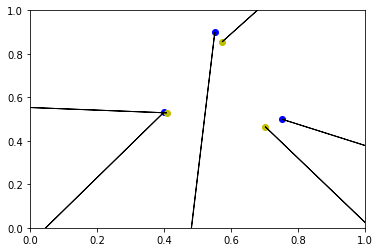

In [1733]:
plt.scatter(xr[0,i,:,0,0], xr[0,i,:,0,1], c='b')
for point in range(3):
    plt.arrow(xr[0,i,point,0,0], xr[0,i,point,0,1],
              xr[0,i,point,1,0]*10-5, xr[0,i,point,1,1]*10-5)
i_shift = i-SERIES_SHIFT
plt.scatter(yr[0,i_shift,:,0,0], yr[0,i_shift,:,0,1], c='y')
for point in range(3):
    plt.arrow(yr[0,i_shift,point,0,0], yr[0,i_shift,point,0,1],
              yr[0,i_shift,point,1,0]*10-5, yr[0,i_shift,point,1,1]*10-5)
plt.xlim(0, 1)
plt.ylim(0, 1)
i += 1

In [1346]:
for i in range(1000):
    x = x_train.get_batch_images()
    ae.train_on_batch(x, x)


In [1347]:
x = x_train.get_batch_images()
y = ae.predict(x)
ae.train_on_batch(x, x)

0.00015128919

In [1348]:
xr = x.reshape(BATCH_SIZE, 3, 2, 2)
yr = y.reshape(BATCH_SIZE, 3, 2, 2)
i = 1

In [1349]:
xr.shape

(32, 3, 2, 2)

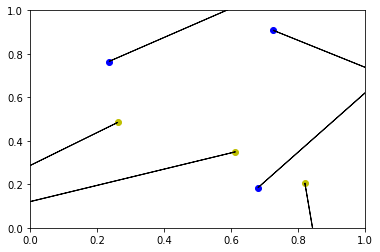

In [1356]:
plt.scatter(xr[i,:,0,0], xr[i,:,0,1], c='b')
for point in range(3):
    plt.arrow(xr[i,point,0,0], xr[i,point,0,1],
              xr[i,point,1,0]*10-5, xr[i,point,1,1]*10-5)
i_shift = i-SERIES_SHIFT
plt.scatter(yr[i_shift,:,0,0], yr[i_shift,:,0,1], c='y')
for point in range(3):
    plt.arrow(yr[i_shift,point,0,0], yr[i_shift,point,0,1],
              yr[i_shift,point,1,0]*10-5, yr[i_shift,point,1,1]*10-5)
plt.xlim(0, 1)
plt.ylim(0, 1)
i += 1

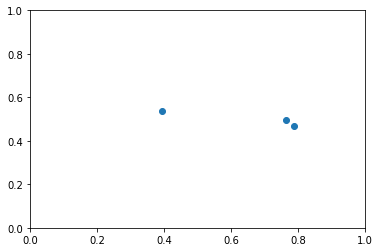

In [516]:
plt.scatter(yr[i,:,0,0], yr[i,:,1,0], cmap='gray')
plt.xlim(0, 1)
plt.ylim(0, 1)
i += 1